In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,20)
import math
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
Aquí lo que hacemos es leer todos los datos, limpiar los valor atípicos y agrupar las ganancias por dia para generar una serie de tiempo con esos valores

In [2]:
df_2019 = pd.read_csv("2019_cleaned.csv")
df_2020 = pd.read_csv("2020_cleaned.csv")
df_2021 = pd.read_csv("2021_cleaned.csv")
df_2022 = pd.read_csv("2022_cleaned.csv")   

dftotal = pd.concat([df_2019,df_2020,df_2021,df_2022])

columnas = dftotal.columns
dftotal['Fecha'] = pd.to_datetime(dftotal[columnas[7]], format='%Y%m%d')
df_clean = dftotal.drop(columns=[columnas[0],columnas[1], columnas[5],columnas[6],columnas[7], columnas[8], columnas[9]])
df_clean

df_clean['Litros'] = df_clean['Litros'].astype(np.str)
df_clean['$'] = dftotal['$'].apply(lambda x: x.replace(',','')).astype(np.int)

dfgrouped= df_clean.groupby(['Fecha'], as_index=False).agg({'$': 'sum'}).reset_index()

#eliminar valores atipicos
colstats = dfgrouped['$'].describe()
q1 = colstats['25%']
q3 = colstats['75%']
IQR = q3-q1
limInf = q1-1.5*IQR
limSup = q3+1.5*IQR
idx = dfgrouped[dfgrouped['$'] < limInf].index
vino_3 = dfgrouped.drop(idx)
idx2 = dfgrouped[dfgrouped['$'] > limSup].index
dfgrouped= dfgrouped.drop(idx2)

dfgrouped.drop(columns=['index','Fecha'],inplace=True)
dfgrouped.reset_index(inplace=True)

In [3]:
def agrupamientoSemanal(df):
    lst=[]
    for i in range(int(len(df)/7)-1):
        week_sum=0
        for j in range(7):
            week_sum+=df[7*i+j]
        lst.append(week_sum/7)
    return lst

In [4]:
weekly_df=pd.DataFrame({'$':agrupamientoSemanal(dfgrouped['$'])})
weekly_df

,$
0,7.204573e+05
1,7.523030e+05
2,7.923524e+05
3,7.795284e+05
4,7.765820e+05
...,...
166,1.061968e+06
167,1.045560e+06
168,1.015443e+06
169,1.022772e+06


In [5]:
del dfgrouped['index']
dfgrouped

,$
0,186439
1,972011
2,968771
3,825223
4,849407
...,...
1201,1052006
1202,1017155
1203,965867
1204,992417


# Predicción a corto plazo
Este es el primer modelo ganador el cual tiene como objetivo predecir de manera considerablemente precisa las dos semanas futuras. Lo que hace es crear una red neuronal recurrente con capas de Long-Short-Memory con secuencias de retorno las cuales son ideales para predecir series de tiempo. Lo que hace esta red neuronal es mirar a los 49 valores anteriores y en base a ellos predice los 14 siguientes. Despues de realizar la optimización de arquitectura concluimos que se tendíran 4 capas, la primera de input de 49 nodos, luego una de 30, otra de 20 y luego una de 14 como output. 

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [7]:
def create_dataset(dataset, look_back, look_ahead):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_ahead-1):
        a,b = dataset[i:(i+look_back), 0] , dataset[(i + look_back):(i + look_back+look_ahead), 0]
        #b = dataset[(i + look_back):(i + look_ahead), 0]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [8]:
def timeSeriesRNN(dataframe,look_back,look_ahead,arch,Epos,batch,plot):
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print(len(train), len(test))

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back,look_ahead)
    testX, testY = create_dataset(test, look_back,look_ahead)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    es = EarlyStopping(monitor='loss', 
                    mode='min', 
                    patience=15,
                    restore_best_weights=True)

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(arch[0], input_shape=(1, look_back),return_sequences=True))
    model.add(LSTM(arch[1]))
    model.add(Dense(look_ahead))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=Epos, batch_size=batch, verbose=2,callbacks=[es])

    if(plot):
        testPrediction=[]
        for i in range(0,int(len(testX)/look_ahead)+1):
            testPrediction.extend(list(scaler.inverse_transform(model.predict(np.reshape(testX[look_ahead*i],(testX[0].shape[0],1,testX[0].shape[1]))))[0])) #linea larga y fea pero que jala osi osi
        x=range(0,len(dataset))
        x1=range(len(dataset)-len(testPrediction),len(dataset))
        plt.plot(x,scaler.inverse_transform(dataset),color='red')
        plt.plot(x1,testPrediction, color='blue')
        plt.show()
    return model

Estos fueron los valores que consideramos dan mejores resultados pero el código esta diseñado para poder cambiarlos facilmente. 

844 362
Epoch 1/150
11/11 - 4s - loss: 0.1903 - 4s/epoch - 359ms/step
Epoch 2/150
11/11 - 0s - loss: 0.1442 - 23ms/epoch - 2ms/step
Epoch 3/150
11/11 - 0s - loss: 0.0909 - 63ms/epoch - 6ms/step
Epoch 4/150
11/11 - 0s - loss: 0.0538 - 33ms/epoch - 3ms/step
Epoch 5/150
11/11 - 0s - loss: 0.0323 - 33ms/epoch - 3ms/step
Epoch 6/150
11/11 - 0s - loss: 0.0218 - 30ms/epoch - 3ms/step
Epoch 7/150
11/11 - 0s - loss: 0.0176 - 31ms/epoch - 3ms/step
Epoch 8/150
11/11 - 0s - loss: 0.0164 - 31ms/epoch - 3ms/step
Epoch 9/150
11/11 - 0s - loss: 0.0162 - 32ms/epoch - 3ms/step
Epoch 10/150
11/11 - 0s - loss: 0.0159 - 33ms/epoch - 3ms/step
Epoch 11/150
11/11 - 0s - loss: 0.0157 - 31ms/epoch - 3ms/step
Epoch 12/150
11/11 - 0s - loss: 0.0155 - 28ms/epoch - 3ms/step
Epoch 13/150
11/11 - 0s - loss: 0.0153 - 31ms/epoch - 3ms/step
Epoch 14/150
11/11 - 0s - loss: 0.0151 - 30ms/epoch - 3ms/step
Epoch 15/150
11/11 - 0s - loss: 0.0148 - 31ms/epoch - 3ms/step
Epoch 16/150
11/11 - 0s - loss: 0.0147 - 32ms/epoch - 3m

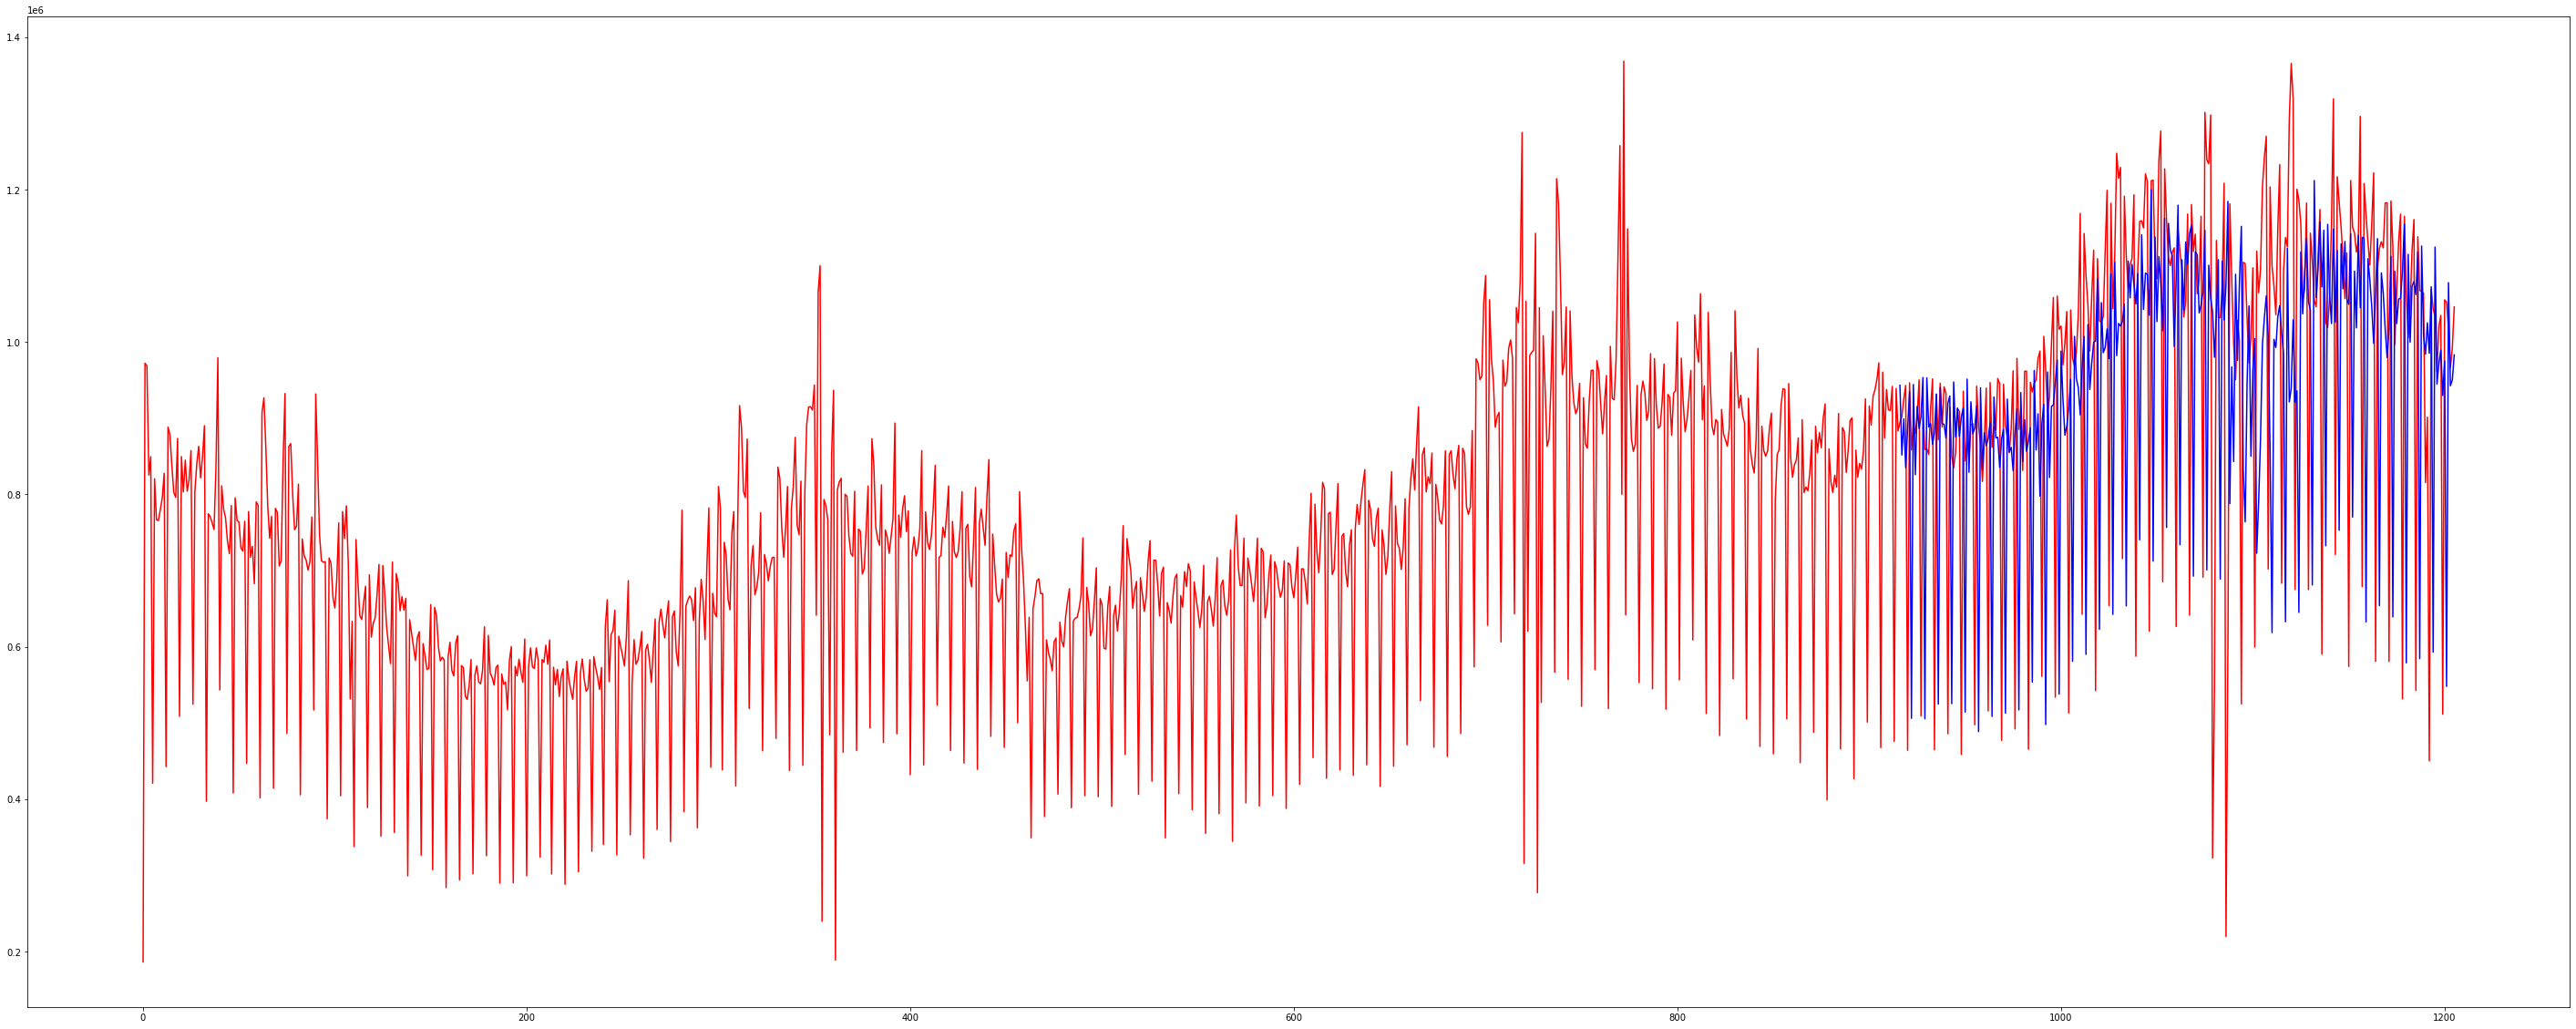

In [14]:
look_back=70
look_ahead=10
architecture=(30,20)
epochs=150
batch=70
rnn=timeSeriesRNN(dfgrouped, look_back, look_ahead, architecture, epochs, batch, plot=True)

# Predicción a largo plazo
Para la predicción de tendencias a largo plazo el mejor modelo de entre los que consideramos fue uno de Holt-Winters. Para este caso se hicierón dos variantes. una la cual considera datos diarios y otra con un agrupamiento semanal de los datos con el objetivo de ver la tendencia general a largo plazo y no enfocarnos en la estacionalidad semanal que existe. 

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

c:\Users\elias\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


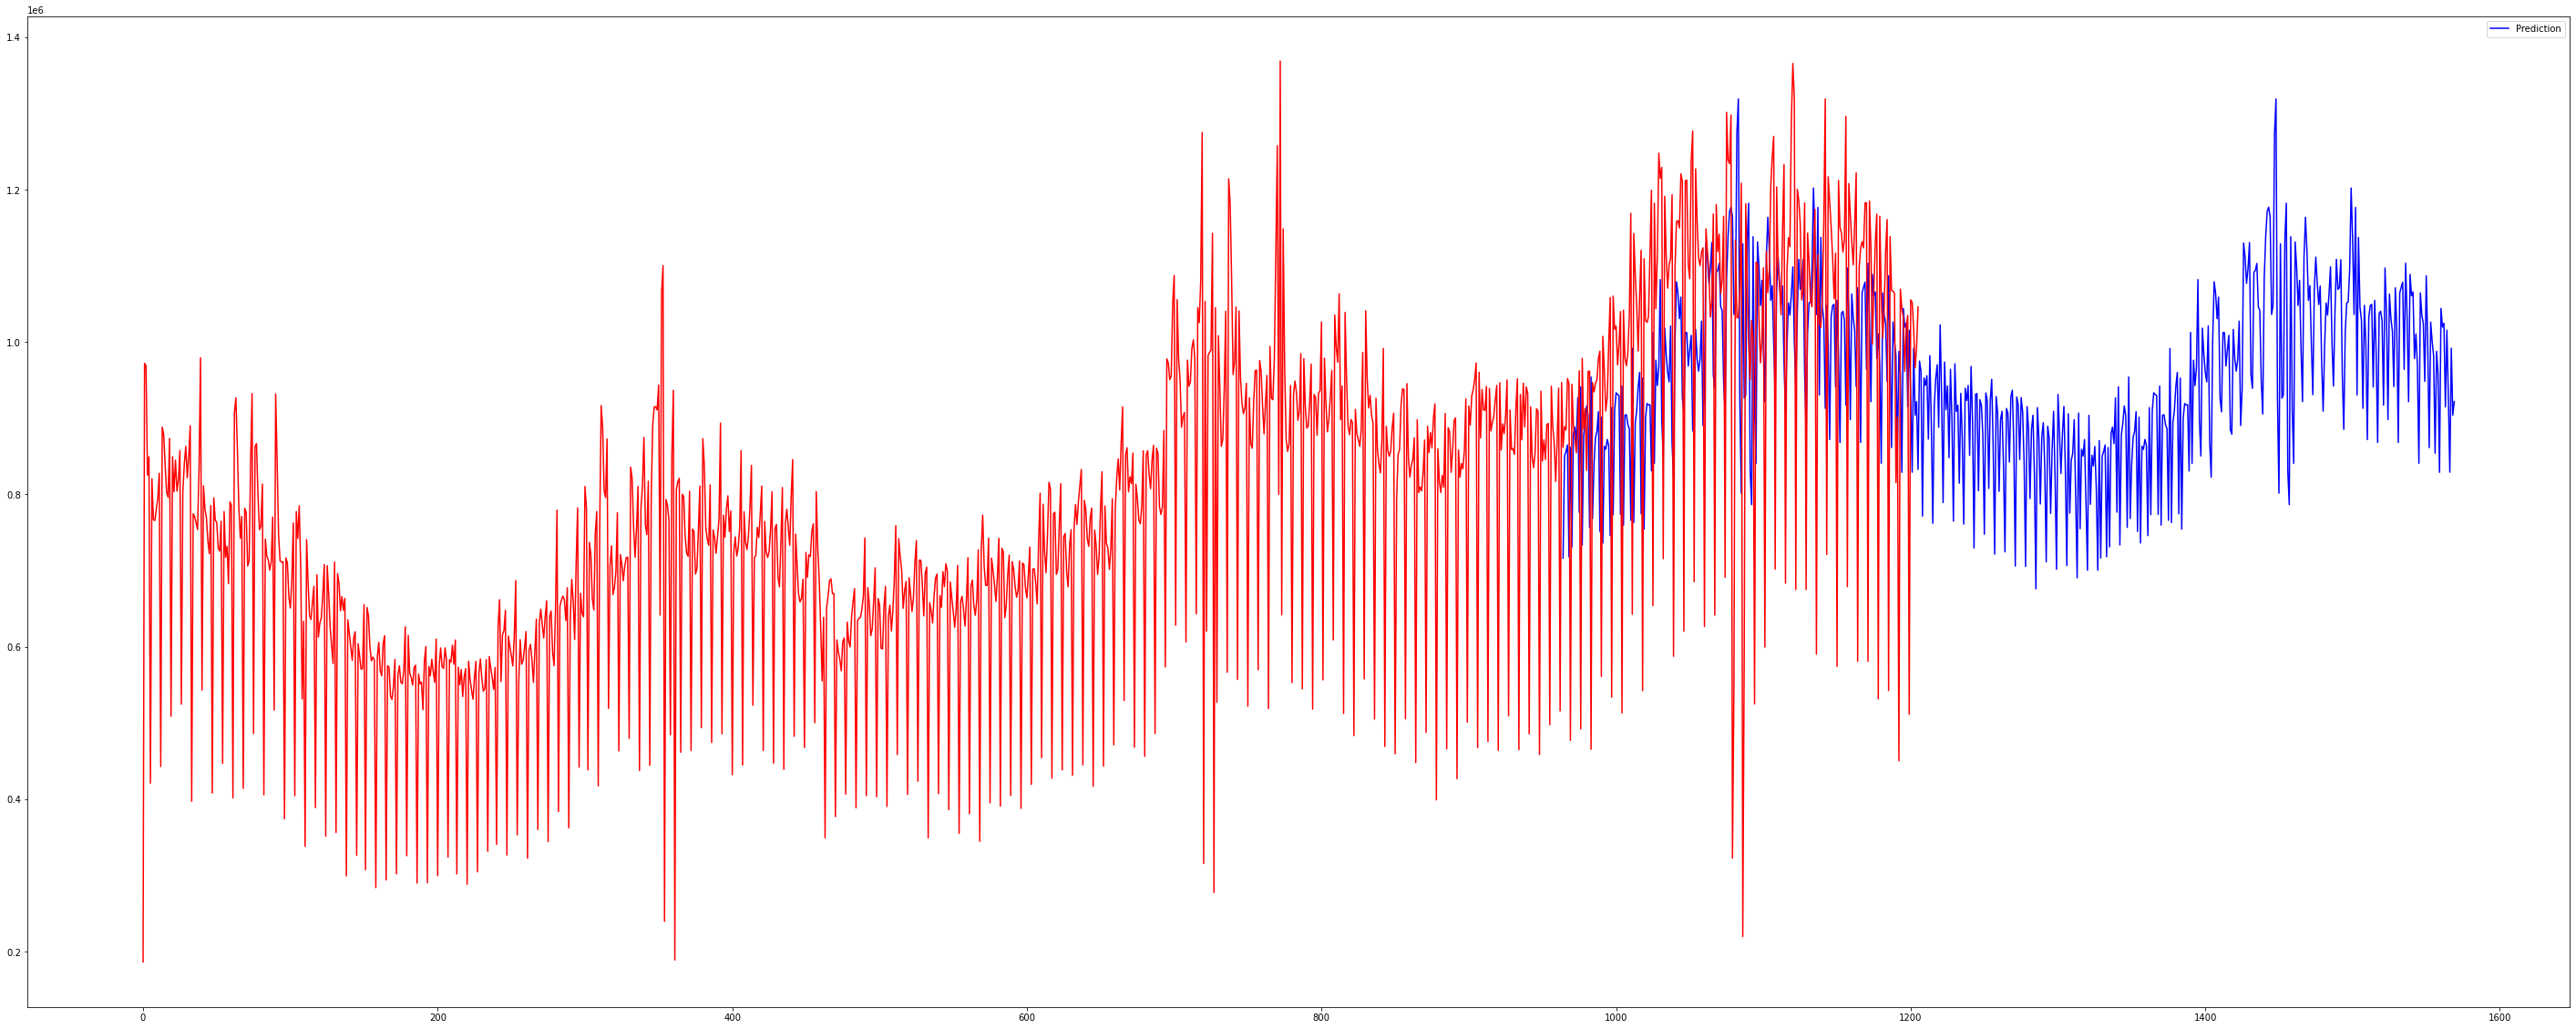

In [11]:
ex_model=ExponentialSmoothing(dfgrouped[0:int(len(dfgrouped)*0.8)],seasonal='add',seasonal_periods=365).fit()
# ex_model.fittedvalues.plot(style='-', color='green')
ex_model.forecast(int(len(dfgrouped)*0.2)+365).plot(style='-', color='blue', legend=True,label='Prediction')
plt.plot(dfgrouped['$'], color = 'red', label = 'Real Revenue')
plt.show()

c:\Users\elias\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


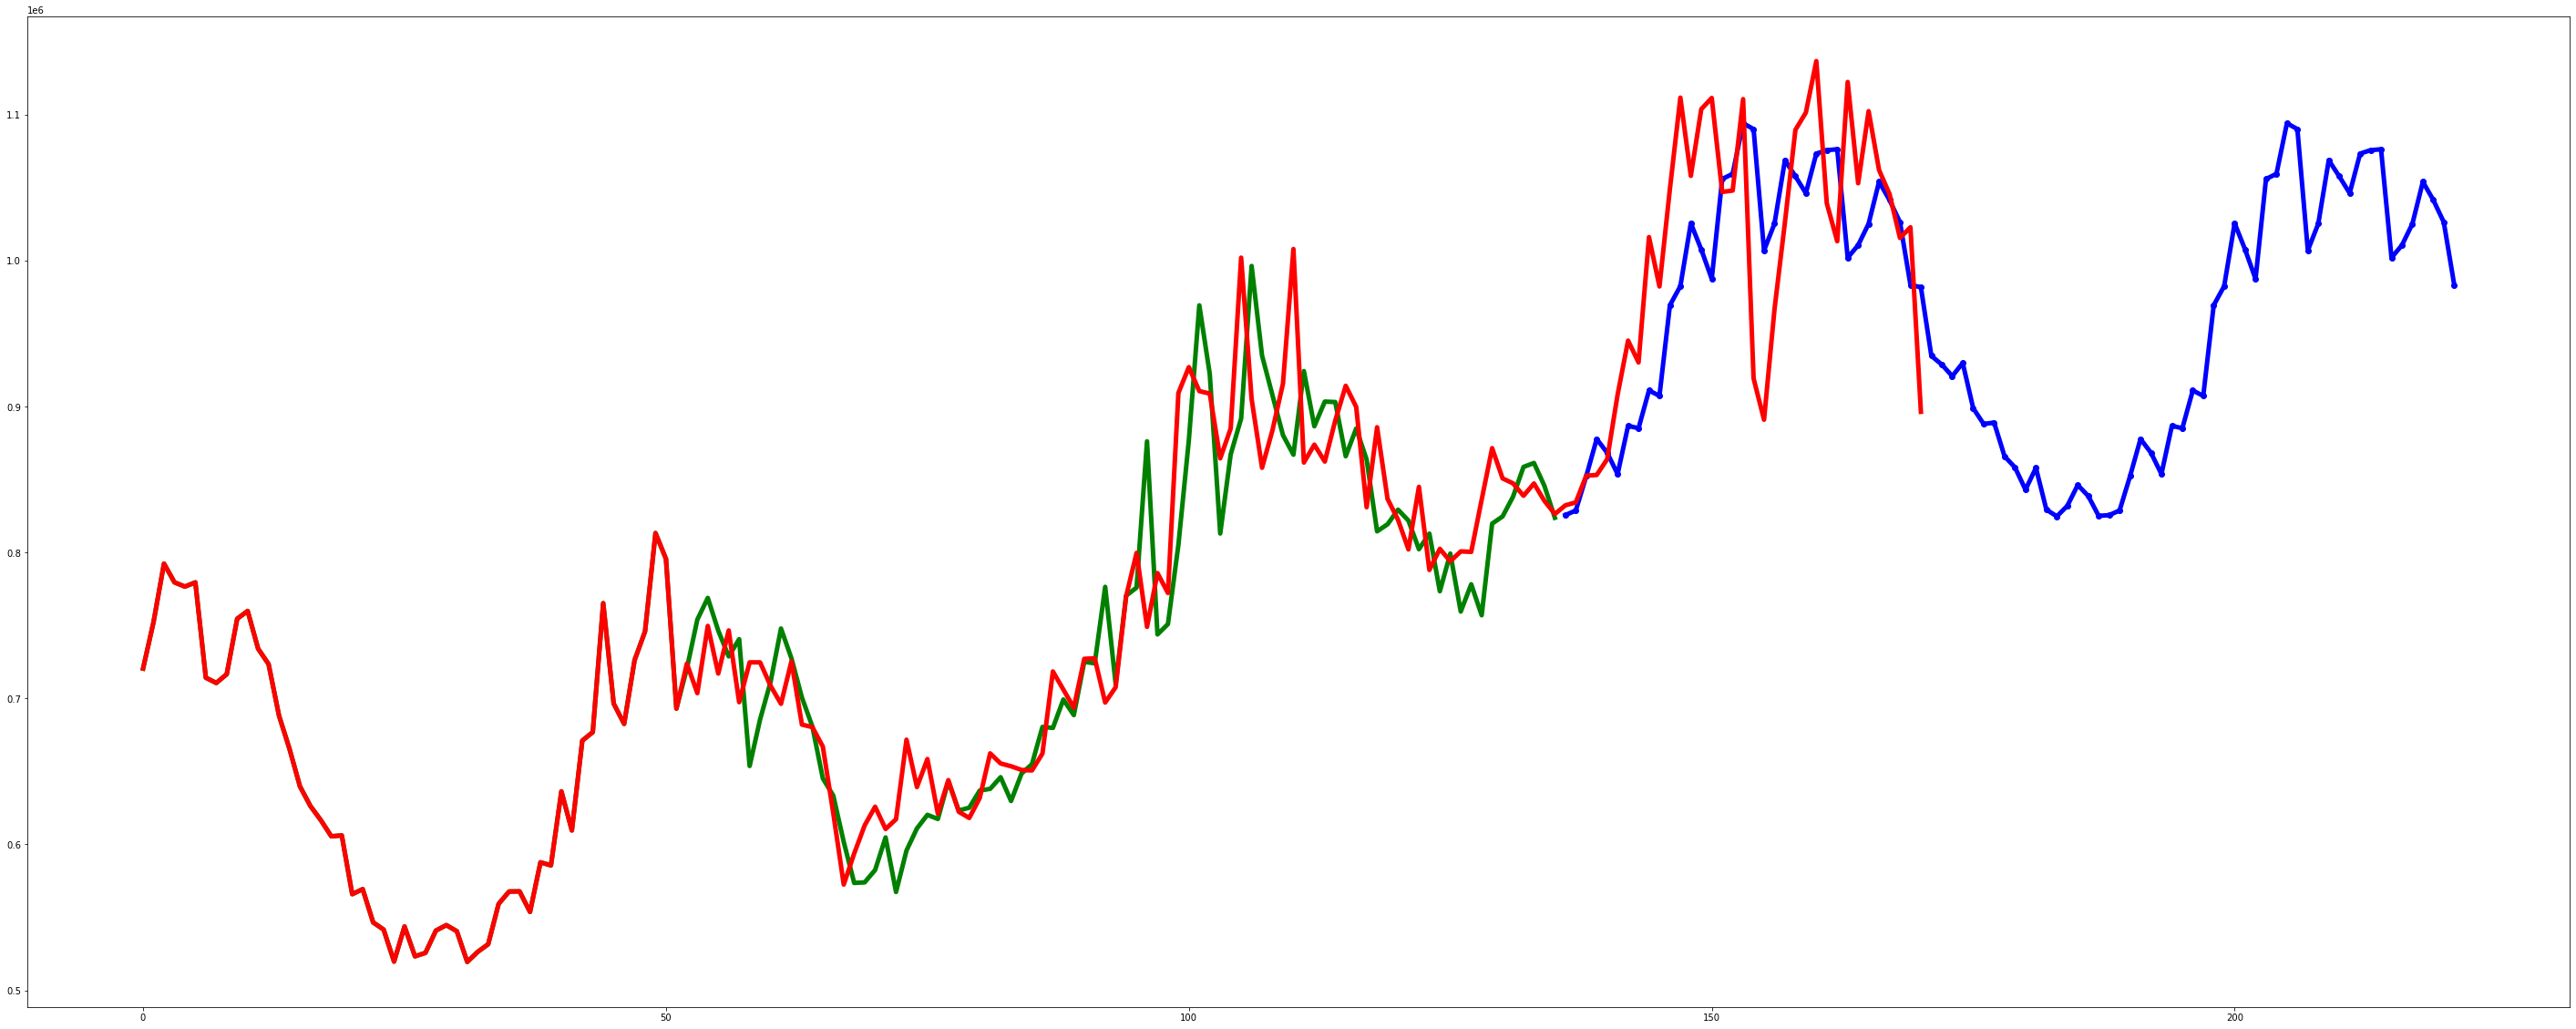

In [12]:
ex_model=ExponentialSmoothing(weekly_df[0:int(len(weekly_df)*0.8)],seasonal='add',seasonal_periods=52).fit()
ex_model.fittedvalues.plot(style='-', color='green',linewidth='5')
ex_model.forecast(int(len(weekly_df)*0.2)+52).plot(style='-', marker='o', color='blue', linewidth='5')
plt.plot(weekly_df['$'], color = 'red', label = 'Real Revenue',linewidth='5')
plt.show()